<a href="https://colab.research.google.com/github/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/Scripts/EDA%2BMachine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This peace of code uses both AutoML Pycaret (logistic regression and LGBM) and Sklearns GridSearchCV, pipeline cabalities to train and tweak XgBoost classifier.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pycaret



     |████████████████████████████████| 266kB 6.3MB/s 
     |████████████████████████████████| 2.0MB 6.5MB/s 
     |████████████████████████████████| 1.4MB 26.4MB/s 
     |████████████████████████████████| 276kB 35.0MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 245kB 43.3MB/s 
     |████████████████████████████████| 1.7MB 44.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.2MB 217kB/s 
     |████████████████████████████████| 6.8MB 41.9MB/s 
     |████████████████████████████████| 174kB 30.6MB/s 
     |████████████████████████████████| 112kB 31.0MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 43.3MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 3.2MB 38.6MB/s 

In [52]:
import csv
from pycaret.classification import *
import math
import pandas as pd
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data = {}
with open('/content/drive/MyDrive/OTCMKT/Final_data.csv') as f:
  csv_file = csv.DictReader(f)
  for idx,row in enumerate(csv_file):
    data[idx]=(dict(row))  

In [5]:
df = pd.DataFrame(data)

In [6]:
df=df.reset_index()

In [7]:

df = df.T
columns = df.loc['index',:]
df = df.drop('index',axis=0)
df = df.rename(columns=columns)

In [8]:
df = df.set_index('Date')


In [9]:
df = df.replace('', '0')


In [10]:
columns = list(df.columns)

In [11]:
columns.remove('Ticker_name')

In [12]:
columns

['Indicator', 'Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']

In [13]:
df[columns]=df[columns].astype(float)

In [14]:
columns.remove('Indicator')
columns.remove('Price')

##Dataset is not *normalized*

In [15]:
from sklearn import preprocessing
print(columns)
x = df[columns].values 
Standard_scaler = preprocessing.StandardScaler()
x_scaled = Standard_scaler.fit_transform(x)
df_new = pd.DataFrame(x_scaled)
df_new.columns = columns

['Sentiment_Score', 'Tweet_counts', 'Volume']


In [16]:
df_new['Indicator'] = list(df.Indicator.values)
df_new['Price'] = list(df.Price.apply(lambda x: math.log1p(x) ).values)
df_new['Tickers'] = list(df.Ticker_name.values)
df_new = df_new.set_index(df.index)

In [17]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [18]:
columns = list(df_new.columns)
columns.remove('Tickers')

In [19]:
columns

['Sentiment_Score', 'Tweet_counts', 'Volume', 'Indicator', 'Price']

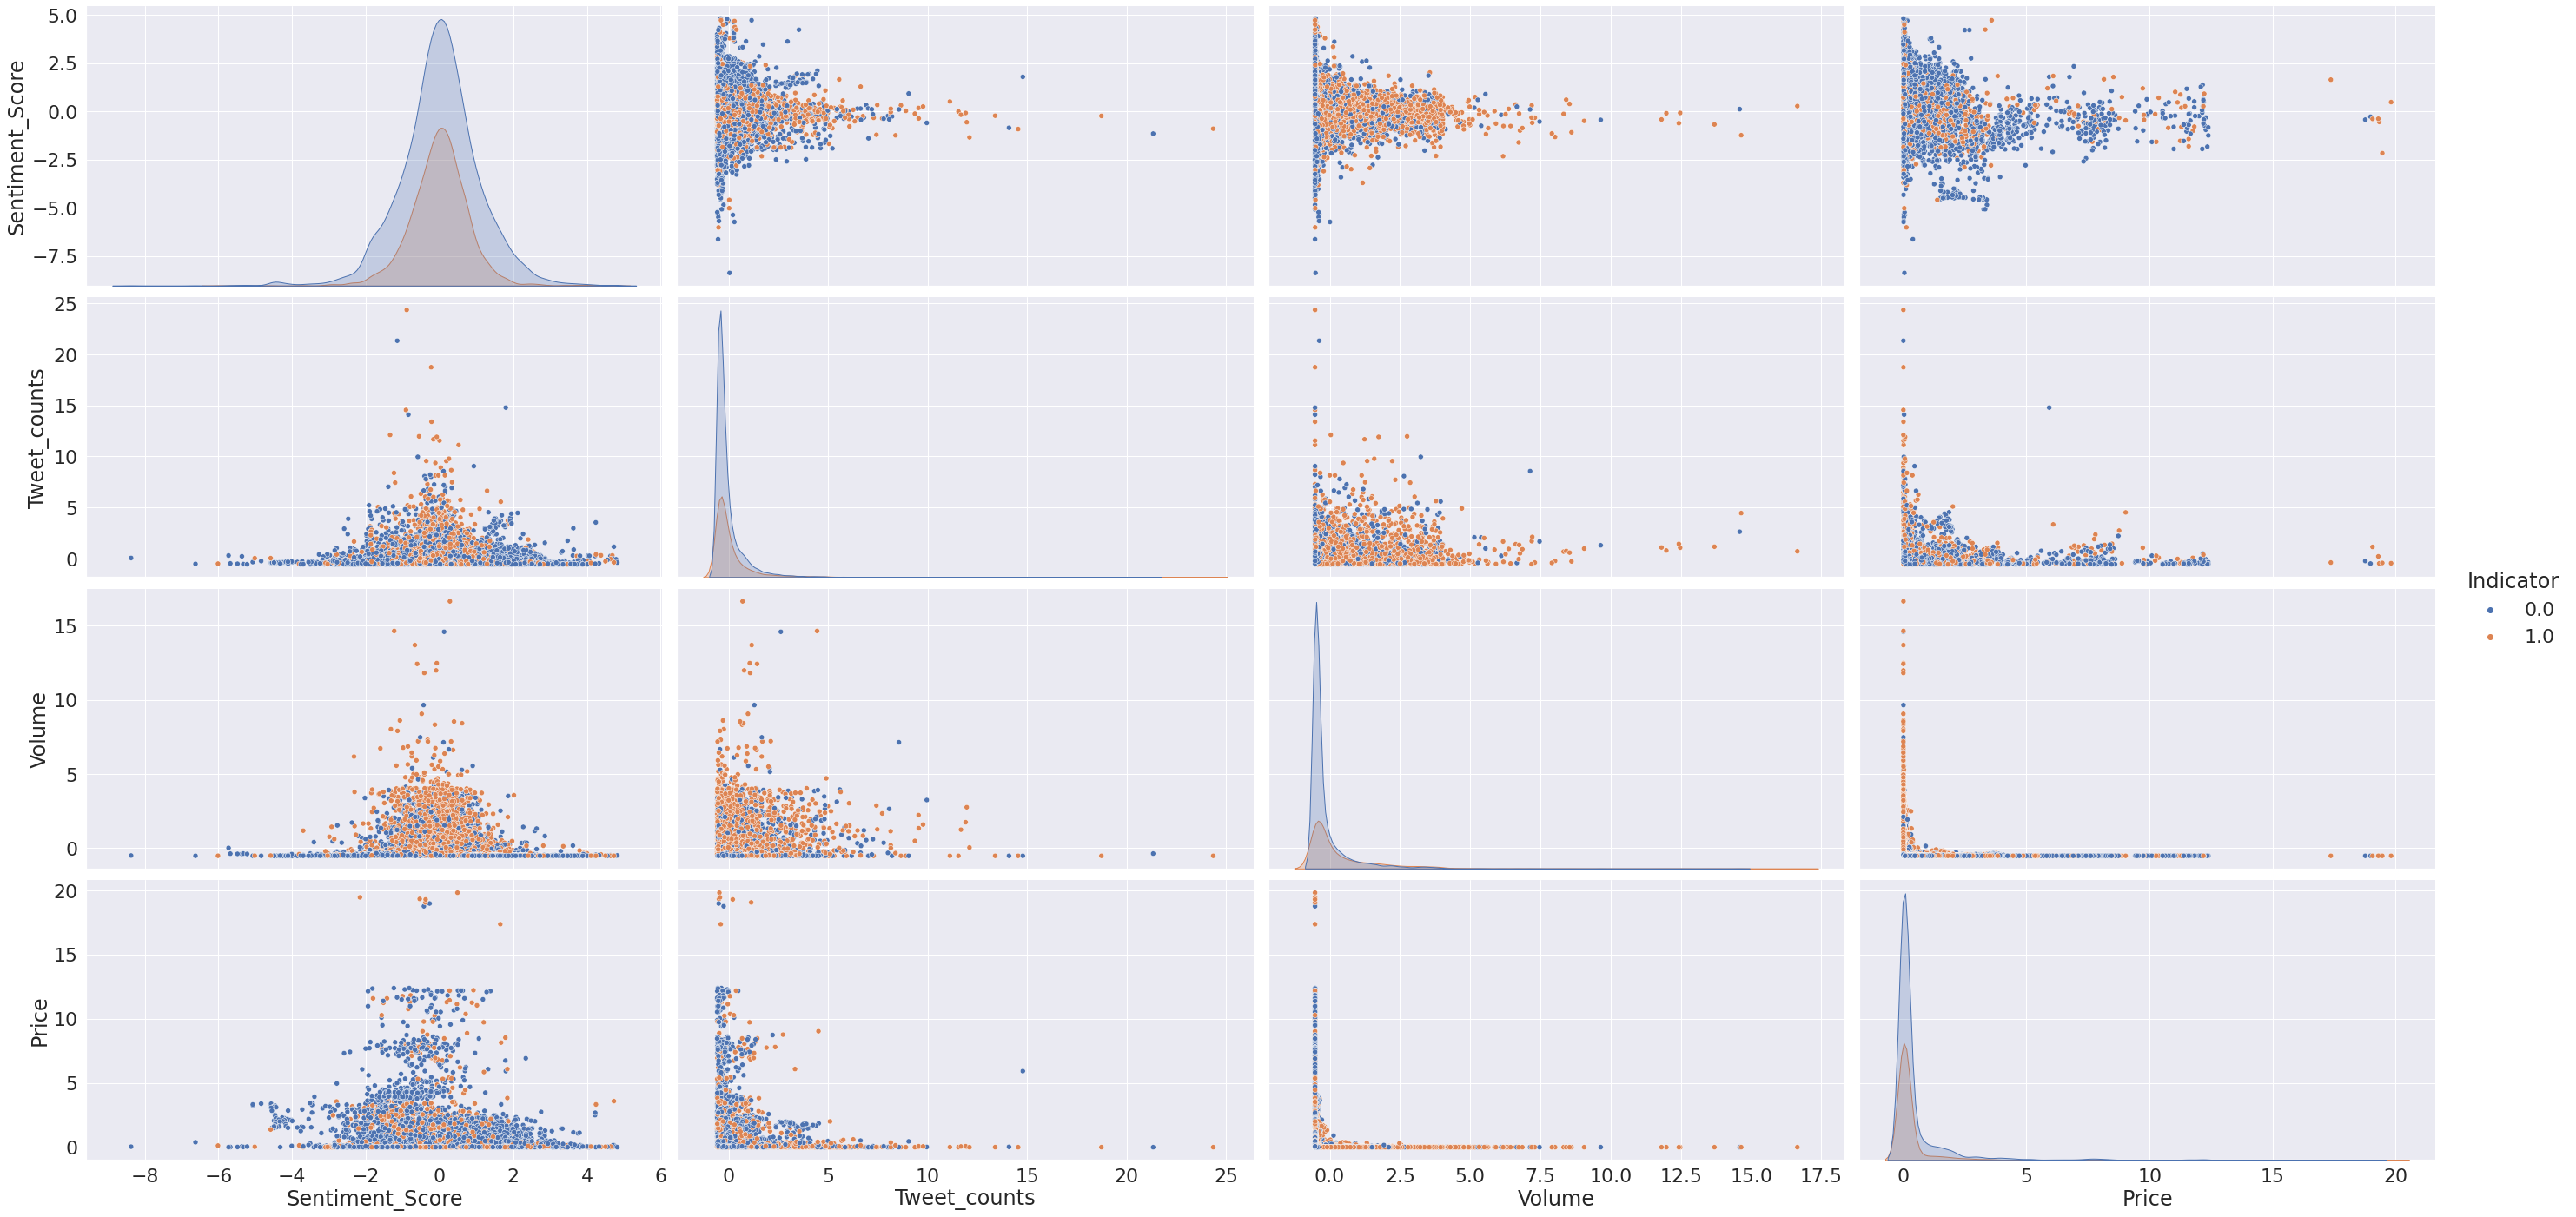

In [20]:
sns.set(font_scale = 2)
sns.pairplot(df_new[columns], hue='Indicator',height=5, 
    aspect=2)


## No collinearity is seen

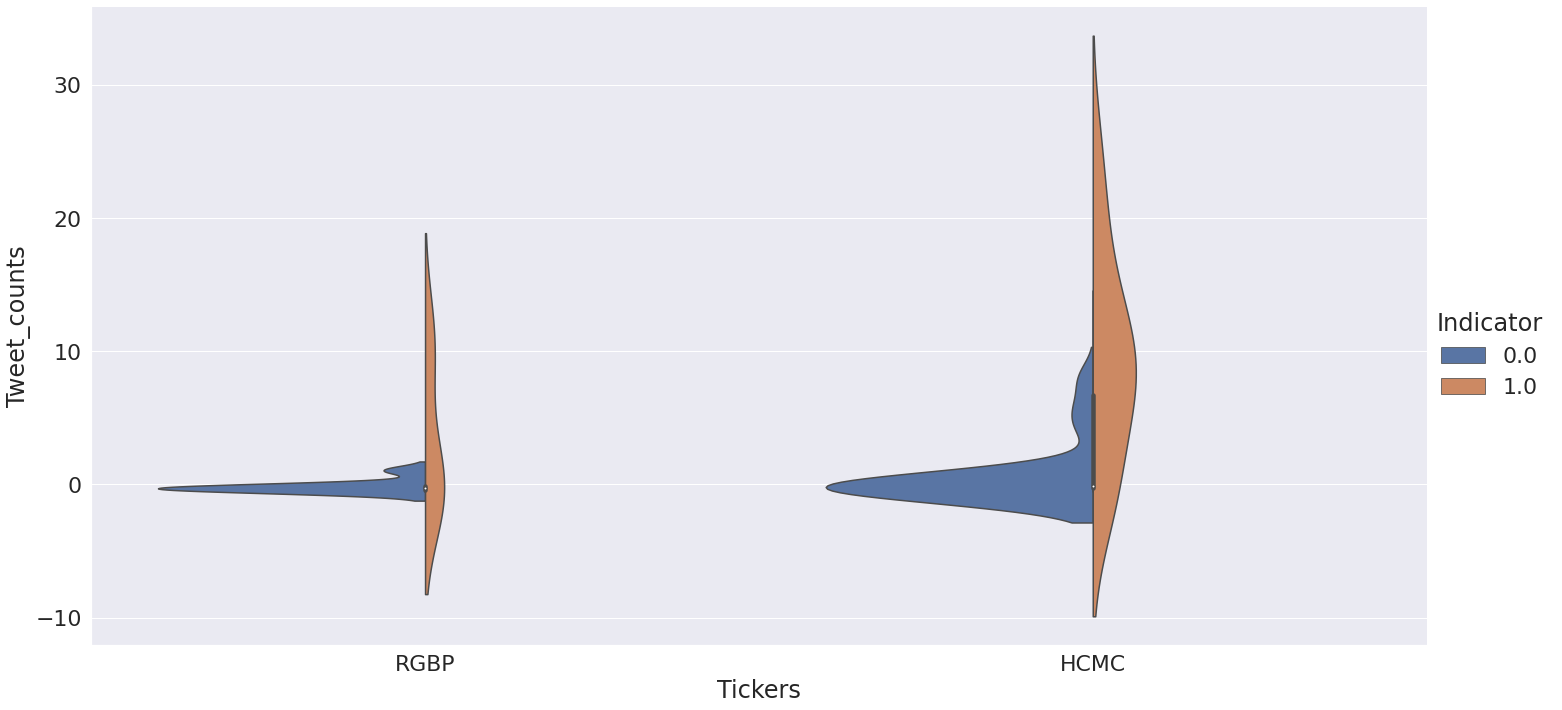

In [21]:

sns.catplot(
    data=df_new[0:50],
    x='Tickers',
    y='Tweet_counts',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175.]),
 <a list of 9 Text major ticklabel objects>)

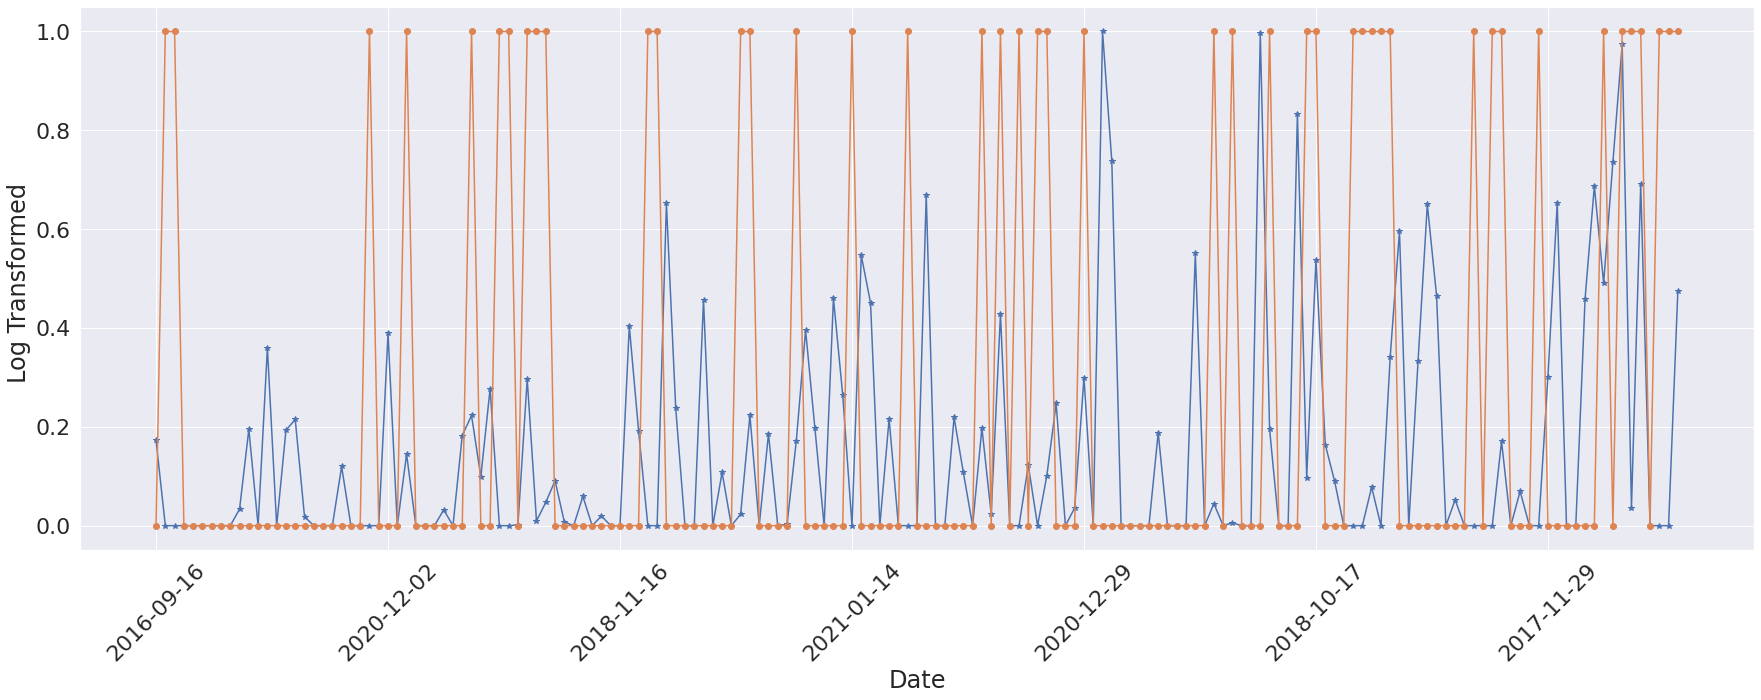

In [22]:
def neg(x):
  if x<0:
    return 0
  elif x>0:
    return x

plot_var = df_new.Sentiment_Score[0::90]
plot_var = plot_var.divide(plot_var.max()).apply(neg)
#plot_var = (plot_var-plot_var.min())/(plot_var.max()-plot_var.min())

plot_var2 = df_new.Indicator[0::90]
plot_var2 = plot_var2/plot_var2.max()
plot_var.plot(x=df_new.index,figsize=(30,10),marker='*')
plot_var2.plot(x=df_new.index,figsize=(30,10),marker='o')
plt.xlabel('Date')
plt.ylabel('Log Transformed ')
plt.xticks(rotation=45)

In [23]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [24]:
exp_clf = setup(df_new, target = 'Indicator',use_gpu=True)

,Description,Value
0,session_id,3281
1,Target,Indicator
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(14819, 6)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7303,0.7444,0.2969,0.6333,0.4043,0.2583,0.2893
1,0.7380,0.7336,0.3312,0.6463,0.4380,0.2896,0.3171
2,0.7312,0.7145,0.2844,0.6454,0.3948,0.2541,0.2894
3,0.7126,0.7204,0.2759,0.5677,0.3713,0.2130,0.2363
4,0.7445,0.7642,0.3166,0.6824,0.4325,0.2951,0.3314
5,0.7319,0.7437,0.3072,0.6323,0.4135,0.2658,0.2949
6,0.7213,0.7043,0.2759,0.6027,0.3785,0.2297,0.2589
7,0.7290,0.7723,0.2594,0.6535,0.3714,0.2377,0.2790
8,0.7445,0.7542,0.3594,0.6571,0.4646,0.3152,0.3400
9,0.7406,0.7551,0.3156,0.6689,0.4289,0.2880,0.3220


In [26]:
tuned_lr = tune_model(lr,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7052,0.7422,0.6344,0.5179,0.5702,0.3494,0.3535
1,0.6965,0.7311,0.6312,0.5063,0.5619,0.3340,0.3388
2,0.6956,0.7129,0.5781,0.5055,0.5394,0.3135,0.3151
3,0.6847,0.7152,0.6395,0.4904,0.5551,0.3174,0.3241
4,0.7271,0.7647,0.6426,0.5481,0.5916,0.3886,0.3914
5,0.6991,0.7426,0.6364,0.5088,0.5655,0.3397,0.3447
6,0.6702,0.7042,0.5925,0.4713,0.5250,0.2774,0.2817
7,0.7348,0.7715,0.6219,0.5637,0.5914,0.3958,0.3968
8,0.6914,0.7554,0.6531,0.5000,0.5664,0.3334,0.3405
9,0.7001,0.7546,0.6625,0.5108,0.5769,0.3506,0.3577


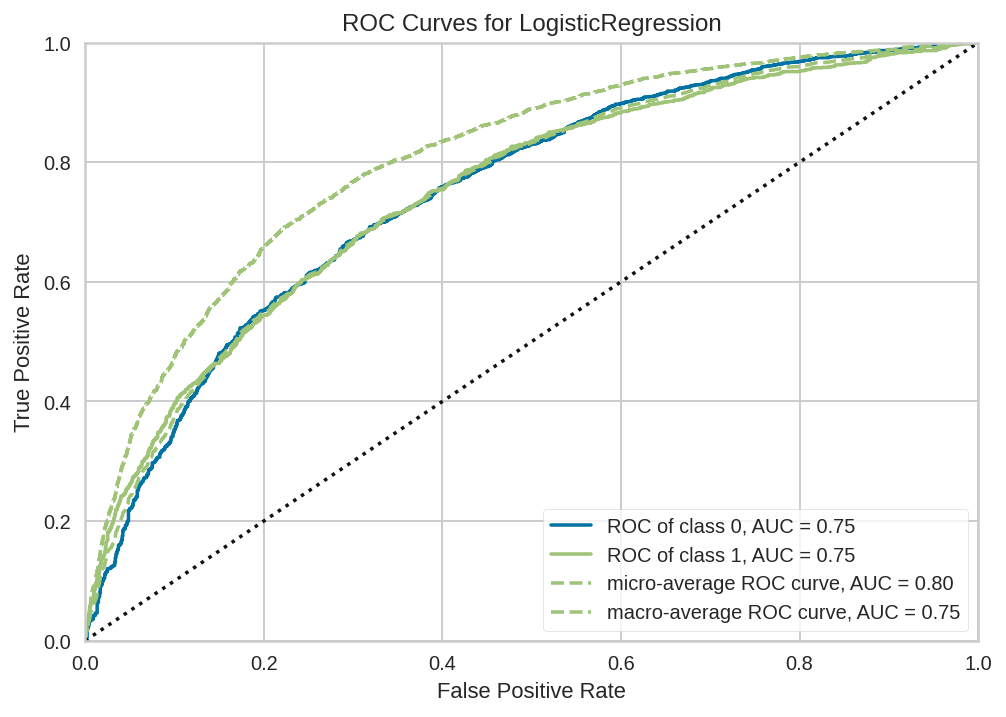

In [43]:
plot_model(lr,'auc',scale=2)

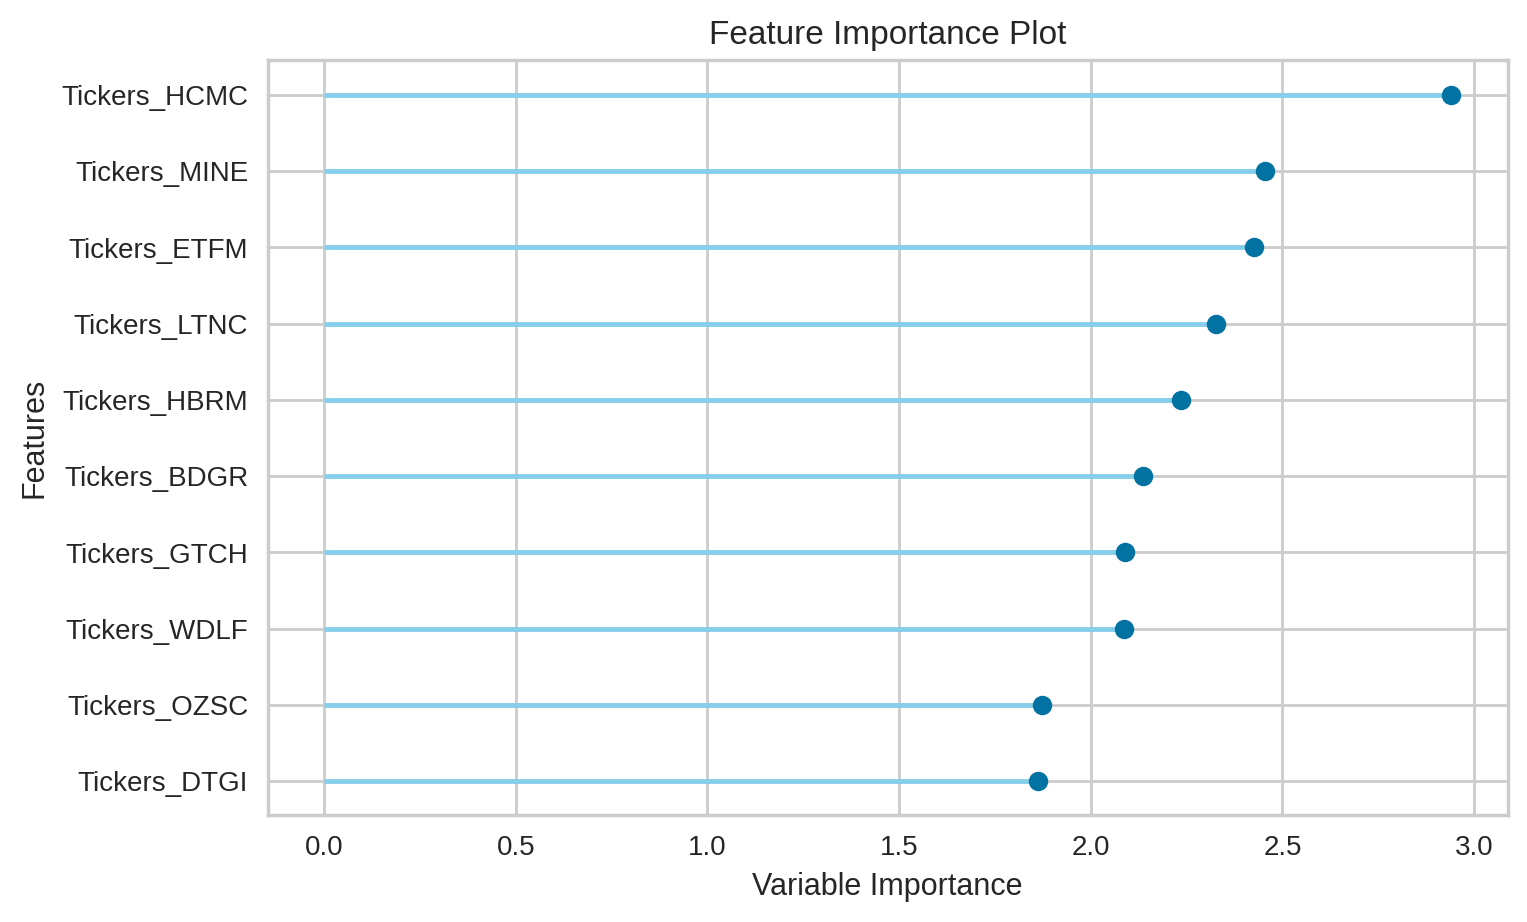

In [28]:
plot_model(lr,'feature',scale=2)

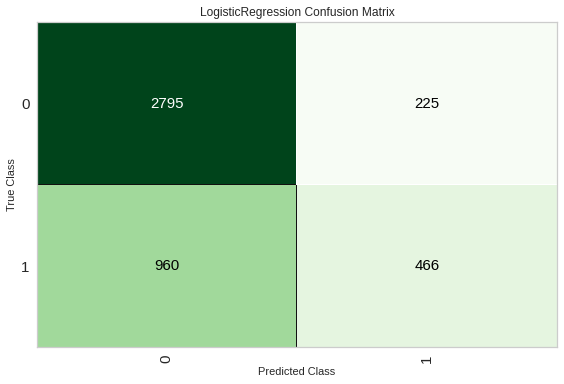

In [29]:
plot_model(lr,'confusion_matrix')

In [30]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7466,0.7994,0.4031,0.6418,0.4952,0.3376,0.3539
1,0.7486,0.7944,0.4469,0.6300,0.5229,0.3588,0.3685
2,0.7514,0.7835,0.4188,0.6505,0.5095,0.3534,0.3687
3,0.7473,0.7910,0.4107,0.6390,0.5000,0.3415,0.3564
4,0.7608,0.8186,0.4420,0.6682,0.5321,0.3803,0.3949
5,0.7483,0.7881,0.4326,0.6330,0.5140,0.3522,0.3638
6,0.7551,0.7915,0.4389,0.6512,0.5243,0.3677,0.3807
7,0.7628,0.8224,0.4344,0.6814,0.5305,0.3821,0.3994
8,0.7493,0.7960,0.4750,0.6230,0.5390,0.3711,0.3775
9,0.7608,0.8084,0.4500,0.6667,0.5373,0.3841,0.3976


In [31]:
tuned_lgbm = tune_model(lgbm,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7274,0.7359,0.4562,0.5725,0.5078,0.3226,0.3266
1,0.7197,0.7306,0.4531,0.5556,0.4991,0.3073,0.3103
2,0.7158,0.7377,0.4625,0.5461,0.5008,0.3041,0.3061
3,0.7203,0.7297,0.4577,0.5551,0.5017,0.3098,0.3126
4,0.7126,0.7194,0.4232,0.5422,0.4754,0.2816,0.2857
5,0.6895,0.7004,0.3918,0.4941,0.4371,0.2266,0.2295
6,0.7068,0.7034,0.4295,0.5290,0.4740,0.2739,0.2767
7,0.7117,0.7424,0.4312,0.5412,0.4800,0.2840,0.2875
8,0.7040,0.7293,0.4719,0.5225,0.4959,0.2871,0.2879
9,0.7020,0.7263,0.4281,0.5209,0.4700,0.2655,0.2680


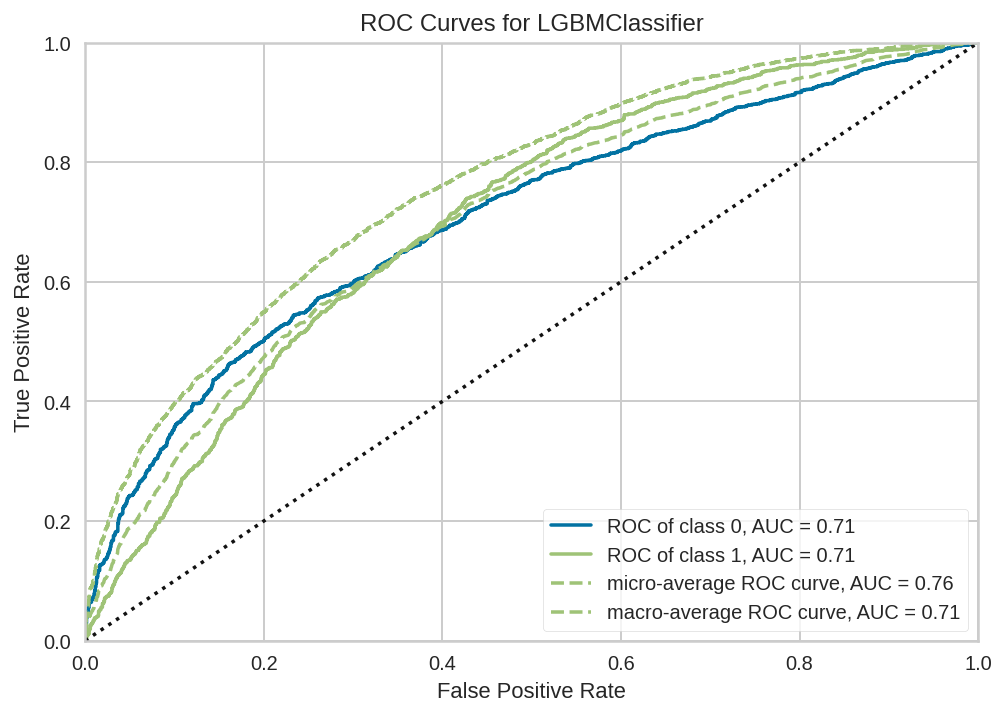

In [42]:
plot_model(tuned_lgbm,'auc',scale=2)

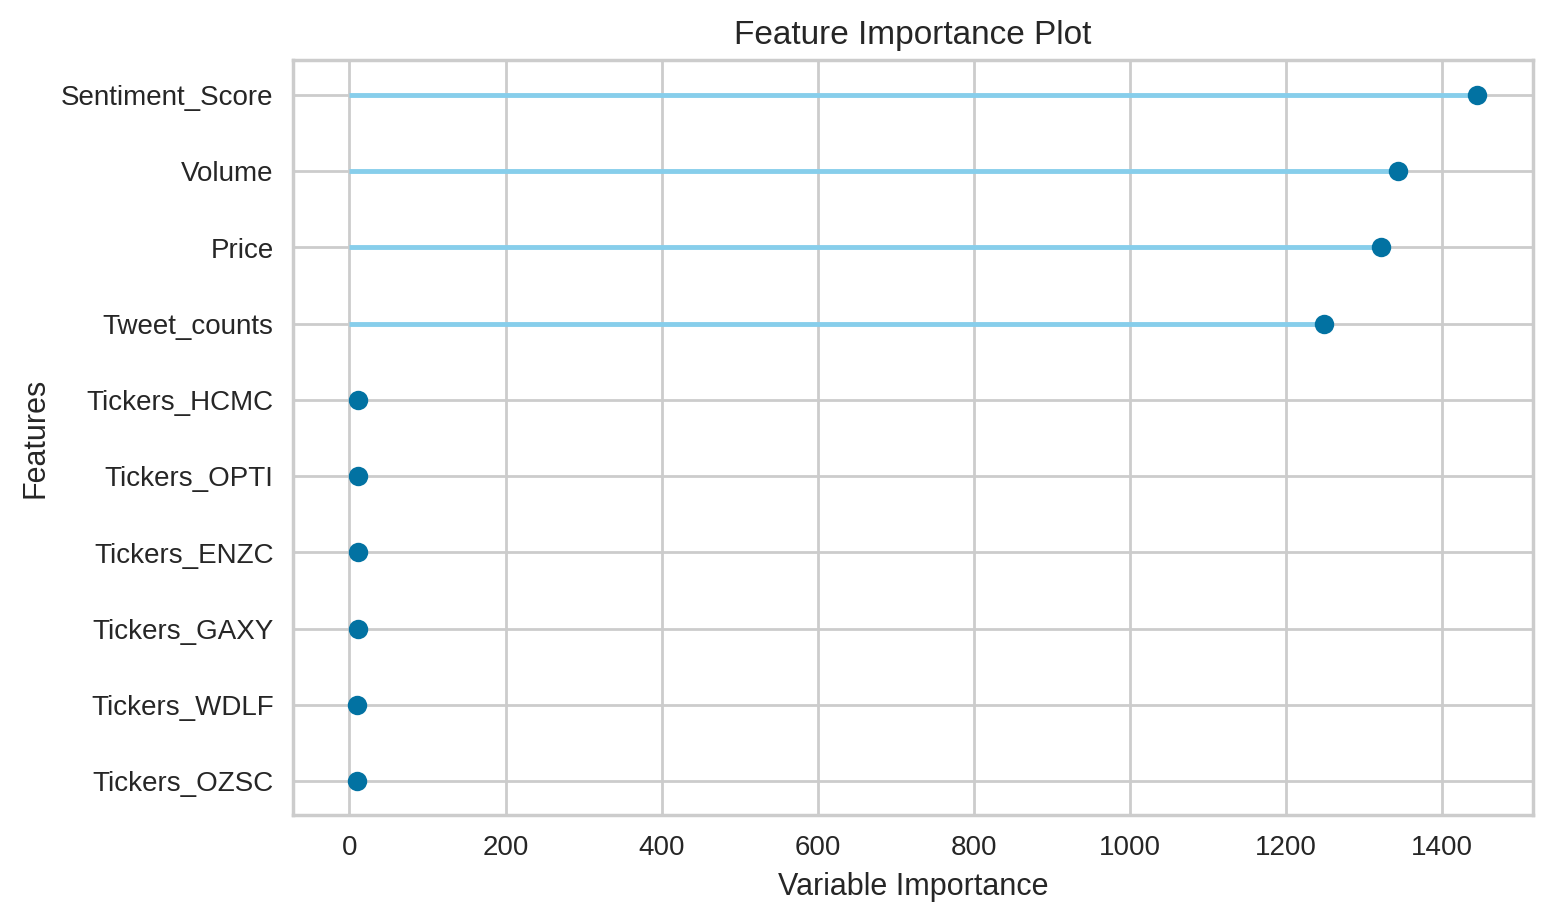

In [33]:
plot_model(tuned_lgbm,'feature',scale=2)

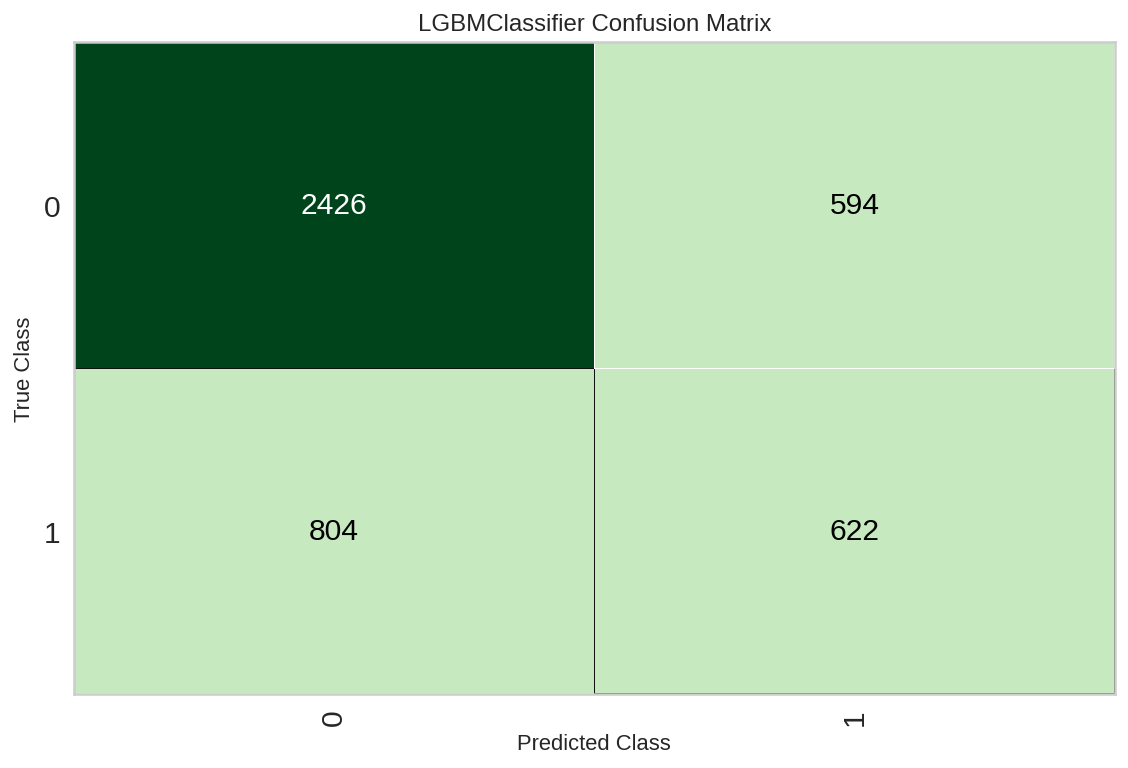

In [34]:
plot_model(tuned_lgbm,'confusion_matrix',scale=2)

## I will use scikit learn for xgboost classifier

In [44]:
import xgboost## Just for checking the help on xbhoost later on
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
## pipeline to combine normalizing and model fitting at once
from sklearn.pipeline import Pipeline
## for model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, precision_recall_curve,average_precision_score, auc

In [45]:
import sklearn.metrics
help(sklearn.metrics.confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

In [57]:


def pipeline_creator(model):

  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  return pipe

def XgboostClassifier(X_test,y_test,X_train,y_train):
  """
  Method to train a basic Xgboost classifier-- essentially a wrapper for my own purpose around the scikit learn methods
  This is without any optimization
  """
  model = xgboost.sklearn.XGBClassifier()

  pipe = pipeline_creator(model)#Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  pipe.fit(X_train,y_train)

  y_pred = pipe.predict(X_test)

  probabilities = pipe.predict_proba(X_test) ## Get prediction probabilities to be used in roc_curve methods

  accuracy = accuracy_score(y_test, y_pred)

  print("Accuracy{}".format (accuracy * 100.0))

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])




  return [tpr_1,fpr_1,fpr_2,tpr_2,y_pred,model,pipe, precision, recall]












In [68]:
(GridSearchCV._get_param_names())

['cv',
 'error_score',
 'estimator',
 'iid',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'refit',
 'return_train_score',
 'scoring',
 'verbose']

In [48]:
GridSearchCV.predict_proba

<function sklearn.model_selection._search.BaseSearchCV.predict_proba>

In [49]:
(xgboost.sklearn.XGBClassifier._get_param_names()) ## check the parameters of this classifier 

['base_score',
 'booster',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'gamma',
 'learning_rate',
 'max_delta_step',
 'max_depth',
 'min_child_weight',
 'missing',
 'n_estimators',
 'n_jobs',
 'nthread',
 'objective',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'scale_pos_weight',
 'seed',
 'silent',
 'subsample',
 'verbosity']

## And will use get dummies method in pandas to generate one hot encoded categorical features.


In [50]:
df_xgboost = pd.get_dummies(df_new)

In [53]:
y = df_xgboost.Indicator
columns_x = list(df_xgboost.columns)
columns_x.remove('Indicator')
X = df_xgboost[columns_x]

sm = SMOTE(random_state=42)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

Accuracy66.98155645524066


Text(0, 0.5, 'True positive rate')

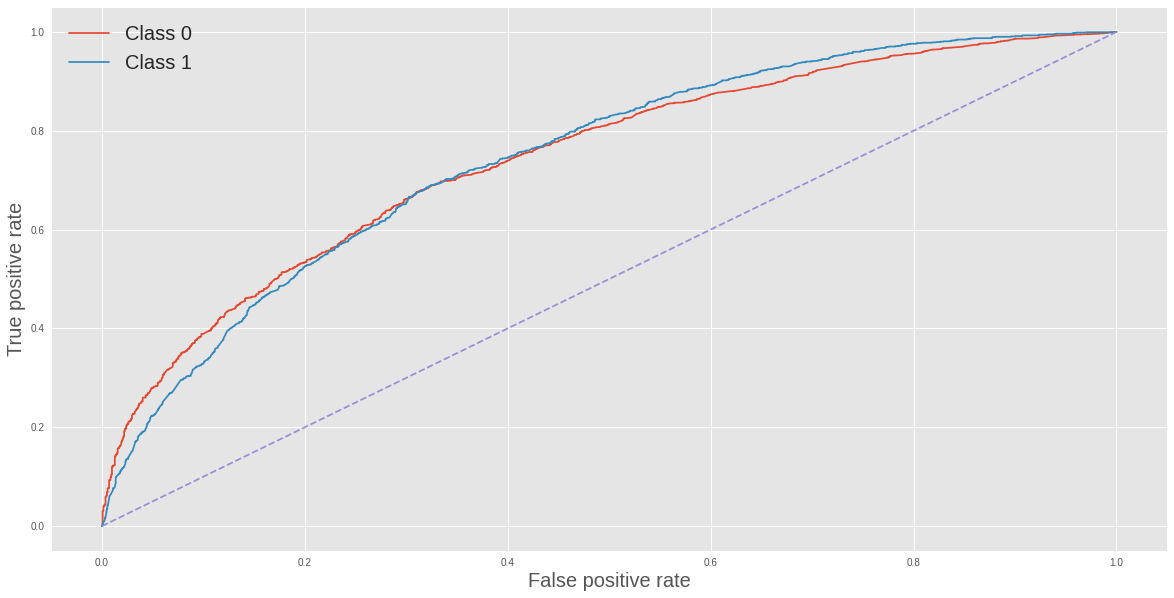

In [61]:
tpr_1, fpr_1, fpr_2, tpr_2, y_pred, model,pipe, precision, recall = XgboostClassifier(X_test,y_test,X_smote,y_smote)
plt.figure(figsize=(20,10))
plt.plot(fpr_1,tpr_1,label='Class 0')
plt.plot(fpr_2,tpr_2,label='Class 1')
plt.legend(loc='best',fontsize=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

In [65]:
#X_train.shape
#X_smote.shape

(10373, 552)

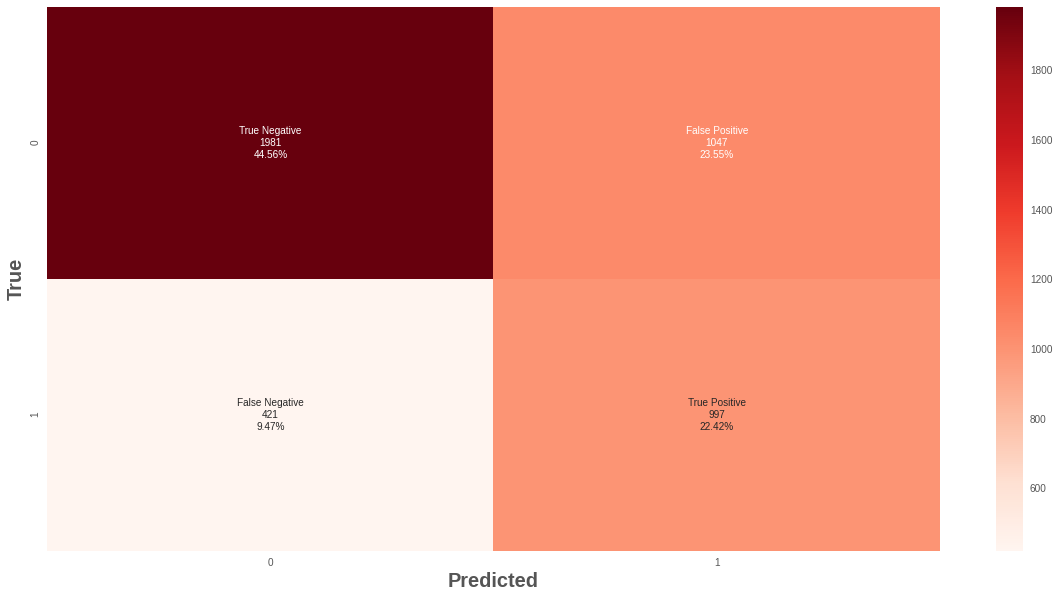

In [66]:



labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()

## Have to add the numbers here and add the precision and recall curve too for the base classifier.

In [67]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
## Optimizing the model using GridSearchCV


def predict_fit( model,folds, metric, X_train, y_train, X_test, y_test):

  """
  This method use gridsearchcv to optimize around the supplied parameters, fit, predict, compute accuracy, precision, recall and roc curve

  """

  grid = GridSearchCV(model, params, cv=folds, scoring=metric)

  grid.fit(X_train, y_train)

  feature_importance = grid.best_estimator_.feature_importances_

  y_pred = grid.best_estimator_.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  probabilities = grid.predict_proba(X_test)## Class prediction probabilities.

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])

  return {'tpr_1':tpr_1,'fpr_1':fpr_1,'fpr_2':fpr_2,'tpr_2':tpr_2,'predictions':y_pred,'model':grid.best_estimator_,'accuracy':accuracy, 'precision':precision, 'recall':recall,'feature_importance':feature_importance}


params = {'learning_rate':[0.1,0.2,0.3],'max_depth':[5,6,7]}

model = xgboost.sklearn.XGBClassifier()

Output = predict_fit(model,6,'recall',X_smote,y_smote,X_test,y_test)
## Pipeline is erroring out for the time being it is fine to use GridSearchCV with XGBoost.
#pipe = pipeline_creator(model)
#grid = search_params(pipe, params, 6, 'precision')
#grid
#grid.fit(X_train,y_train)
#acc = predict(grid,X_train,y_train, X_test, y_test)
#print("Accuracry is {}".format(acc))
#parameter_tuning(pipe,params,6,'precision',X_test,y_test,X_train,y_train)

In [ ]:
Output.keys()

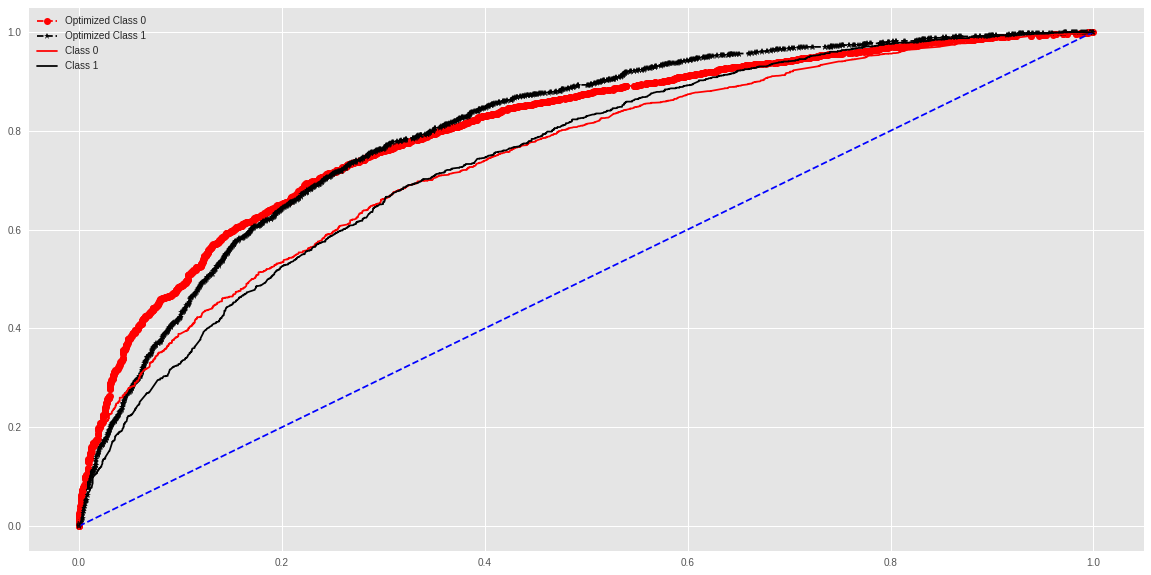

In [73]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],'--o',label='Optimized Class 0',color='red')
plt.plot(Output['fpr_2'],Output['tpr_2'],'--*',label='Optimized Class 1',color='black')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--',color='blue')
plt.plot(fpr_1,tpr_1,label='Class 0',color='red')
plt.plot(fpr_2,tpr_2,label='Class 1',color='black')
plt.legend(loc='best')


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

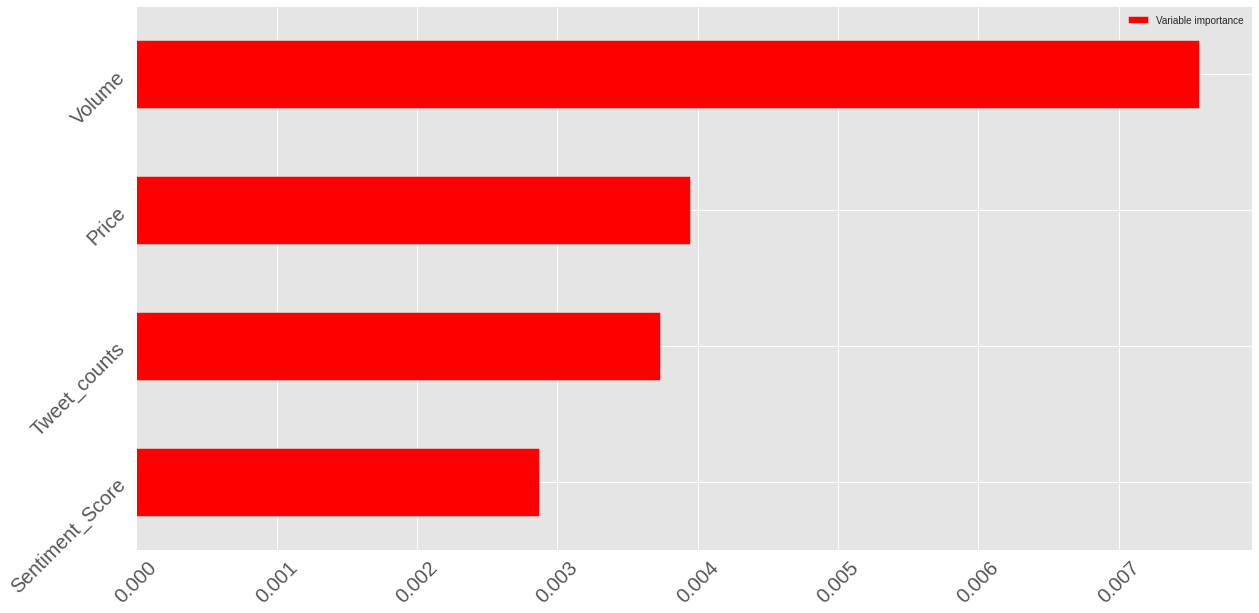

In [74]:

feature_names = list(df_xgboost.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame((Output['model']).feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)

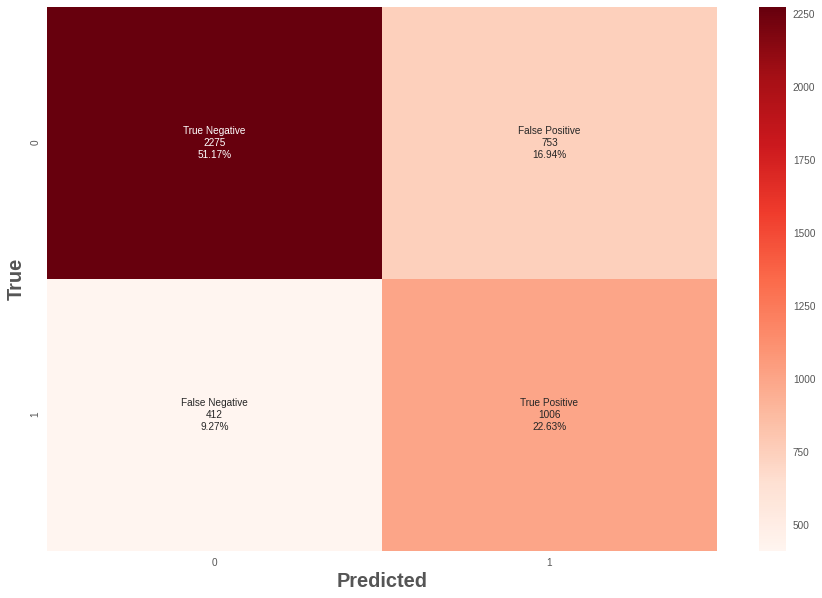

In [71]:


labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,Output['predictions'])
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()


## I will plot precision and recall--this should end the modeling part after I finish CatBoost classifier with Sklearn.

## Optimization results in a better True positive classification

In [ ]:
#!pip install catboost


In [ ]:
#from catboost import CatBoostClassifier